In [1]:
## Connect Google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [2]:
#! pip install xgboost
#Documentation for GPU: https://xgboost.readthedocs.io/en/latest/gpu/index.html#

In [3]:
## Importing libraries
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import pandas as pd
import pickle
import os
from keras.models import Model
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import img_to_array 

import random
#IOU(Intersection over Union)
from keras.metrics import MeanIoU
from sklearn import metrics

#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
import seaborn as sns

#XGBOOST
import xgboost as xgb
#Define gpu_id, otherwise it uses CPU and would take longer



#Split training data
from sklearn.model_selection import train_test_split

#label encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [4]:
#pat = "/content/gdrive/MyDrive/Hot Data"    #previous data
#print(os.listdir("/content/gdrive/MyDrive/Hot Data"))

pat = "/content/gdrive/MyDrive/Georef v2"
print(os.listdir(f"{pat}"))

SIZE = 256 

['1commands.bat', '2commands.bat', '3commands.bat', '4commands.bat', '5commands.bat', 'Georeferencing.ipynb', '4', '3', '5', '1', '.ipynb_checkpoints', '2']


In [5]:
def img_array(path, num):
  """
  Function to load features and labels for training
  inputs: path=path to dataa and number= for specifying folder number of 5"""
  img = glob.glob(f"{pat}/{num}/*[19|20|21].png")   #match file names with 19, 20, 21 zoom level
  img.sort()
  img = [cv2.imread(image, 1) for image in img] 
  img = np.array(img)
  print("Shape of image data is: ", img.shape)

  ras = glob.glob(f"{pat}/{num}/*-burned.png")
  ras.sort()
  ras = [cv2.imread(image, 0) for image in ras] 
  ras = np.array(ras)
  print("Shape of raster data is: ", ras.shape)
  return img, ras

In [6]:
def vis_data(img, ras):
  """
  Function for visualizing dataset before training"""
  for i in range(10):  #visualize first 10 images and rasters before prediction
    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Image')
    plt.imshow(img[i], cmap='viridis')
    plt.subplot(232)
    plt.title('Raster')
    plt.imshow(ras[i])
    plt.show()

In [7]:
def encode(train_ras):
  labelencoder = LabelEncoder()
  num, hei, wid = train_ras.shape 
  print(num, hei, wid) 
  reshaped_ras = train_ras.reshape(-1,1)  #reshape data array to 1d array
  encoded_ras = labelencoder.fit_transform(reshaped_ras)  #transform array
  encoded_ras = encoded_ras.reshape(num, hei, wid)  #reshape encoded array


  np.unique(encoded_ras)
  return encoded_ras

In [8]:
def vis_vgg():

  """
  Function for loading vgg model
  """
  
  VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))


  #No trainable layer selected
  for layer in VGG_model.layers:
    layer.trainable = False

     
  display(VGG_model.summary() ) 

  # Extract only 2 conv layers/blocks
  new_vgg = Model(inputs=VGG_model.input, outputs=VGG_model.get_layer('block1_conv1').output)
  display(new_vgg.summary())

  return new_vgg

In [9]:
def vis_results(X_test, new_vgg, load_model):
  for i in range(5):  #visualize first ten images, rasters and prediction
    img_number = i
    img = X_test[img_number]
    img = np.expand_dims(img, axis=0)

    img_features = new_vgg.predict(img)
    img_features = img_features.reshape(-1, img_features.shape[3])
    mask = y_test[img_number]

    prediction = load_model.predict(img_features)
    predicted_rast = prediction.reshape(mask.shape[0], mask.shape[1])




    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Image')
    plt.imshow(img[0], cmap='viridis')
    plt.subplot(232)
    plt.title('Raster')
    plt.imshow(mask)
    plt.subplot(233)
    plt.title('Prediction')
    #plt.imshow(predicted_rast[i])
    plt.imshow(predicted_rast)
    plt.show()
  

Performing training on folder 2
Shape of image data is:  (147, 256, 256, 3)
Shape of raster data is:  (147, 256, 256)


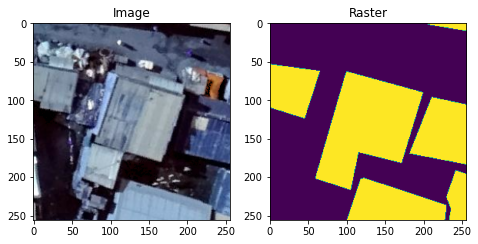

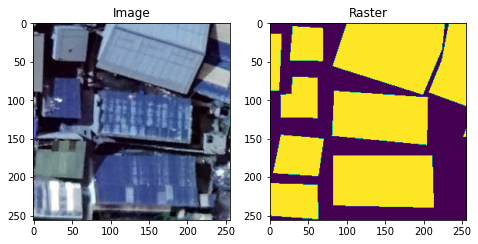

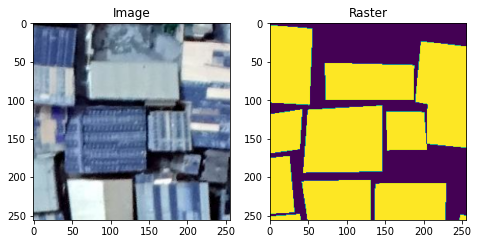

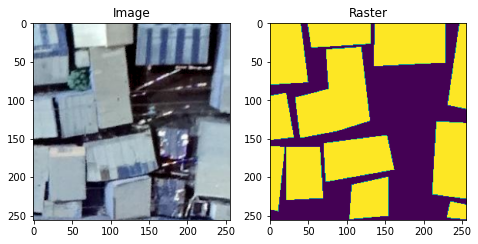

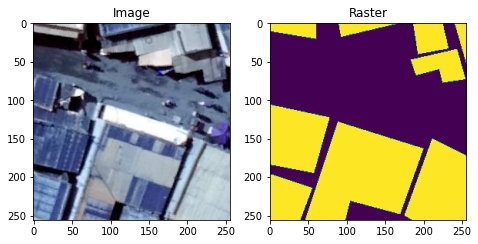

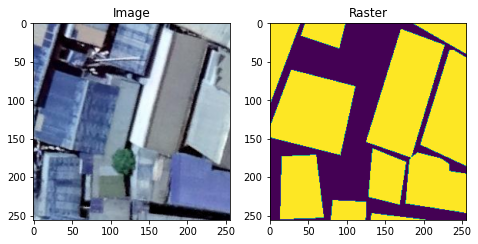

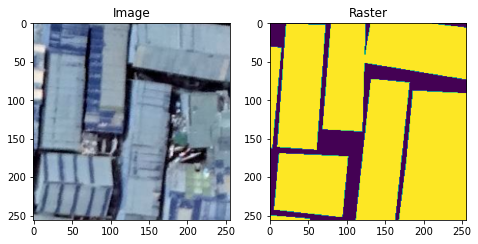

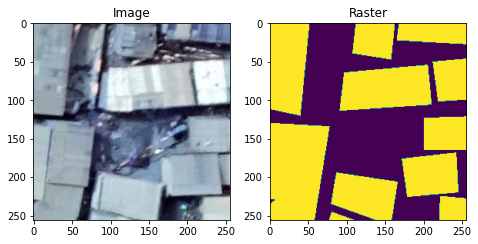

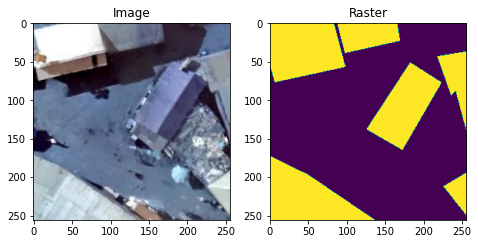

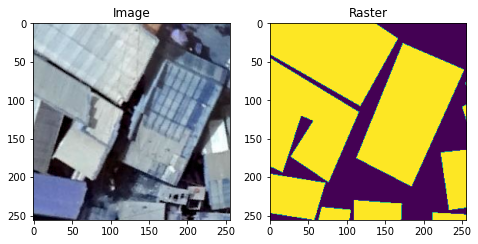

147 256 256


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0 1]
58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                        

None

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
Total params: 1,792
Trainable params: 0
Non-trainable params: 1,792
_________________________________________________________________


None

4/4 [==============================] - 8s 83ms/step
(7667712, 64)
(7667712,)
1/1 [==============================] - 0s 137ms/step
(1966080, 64)
(1966080,)
(1966080,)
Accuracy =  0.8995564778645834
Precision =  0.8246071312826241
Recall =  0.8332369479030943
Mean IoU = 0.7875283




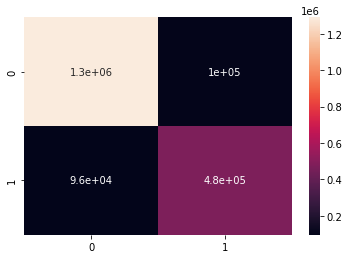

In [11]:
for i in range(1):

  i = 1  #for training with all file folders, this line can be removed and range() set to 5
  print('\033[1m' + f"Performing training on folder {i+1}" + '\033[0m')

  train_img , train_ras = img_array(pat, i+1)



  vis_data(train_img, train_ras)

  enc_ras = encode(train_ras)
  print(np.unique(enc_ras))

  #Normalize images
  train_img = train_img /255.

  X_train, X_test, y_train, y_test = train_test_split(train_img, enc_ras, test_size = 0.2, random_state = 42)


  #visualize vgg model specs for selection based on data specs
  new_vgg = vis_vgg()

  # Extract features from convolutional layers
  features = new_vgg.predict(X_train)




  #Reassign 'features' as X 
  X=features

  # Reshape X to match with labels that can be used for XGBoost model

  X = X.reshape(-1, X.shape[3])  

  print(X.shape)

  #Reshape Y to match X
  Y = y_train.reshape(-1)
  print(Y.shape)

  np.unique(Y)

  #model classifier
  #model = xgb.XGBClassifier()  

  model = xgb.XGBClassifier(tree_method='gpu_hist', gpu_id=0, n_extimators = 1000, max_depth = 12, gamma = 1)

  # Train model
  model.fit(X, Y)


  model_path = f'{pat}/{i+1}/model.sav'
  pickle.dump(model, open(model_path, 'wb'))   #save model
  #Load model
  load_model = pickle.load(open(model_path, 'rb'))


  #test
  X_test_features= new_vgg.predict(X_test)  #extract convolutional layers from test data
  X_test_features= X_test_features.reshape(-1, X_test_features.shape[3])  #reshape data
  print(X_test_features.shape)

  y_pred = load_model.predict(X_test_features)   #predict based on test features
  print(y_pred.shape)

  test_labels = y_test.reshape(-1)  #reshape test labels
  print(test_labels.shape)

  #evaluate using confusion matrix
  cm = confusion_matrix(test_labels, y_pred)
  #print(cm)
  sns.heatmap(cm, annot=True)

  #Print overall accuracy, precision and recall not just pixel accuracy
  print ("Accuracy = ", metrics.accuracy_score(test_labels, y_pred))  
  print ("Precision = ", metrics.precision_score(test_labels, y_pred))
  print ("Recall = ", metrics.recall_score(test_labels, y_pred))

  #Using built in keras function

  #Keras IOU evaluation
  n_classes = 2
  IOU_keras = MeanIoU(num_classes=n_classes)  
  IOU_keras.update_state(test_labels, y_pred)
  print("Mean IoU =", IOU_keras.result().numpy())

  #vis_results(X_test, new_vgg, load_model)
  


  print()
  print()

1/1 [==============================] - 0s 54ms/step


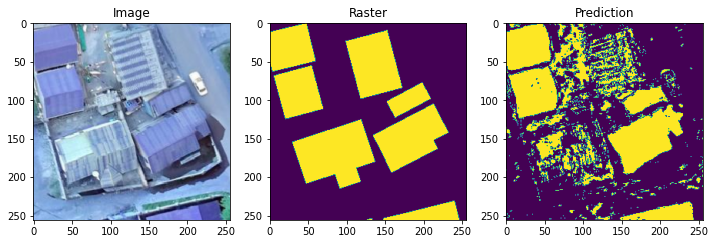

1/1 [==============================] - 0s 20ms/step


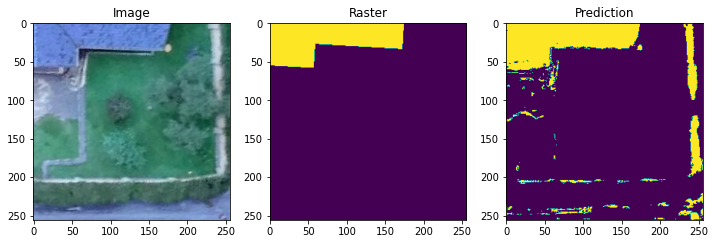

1/1 [==============================] - 0s 16ms/step


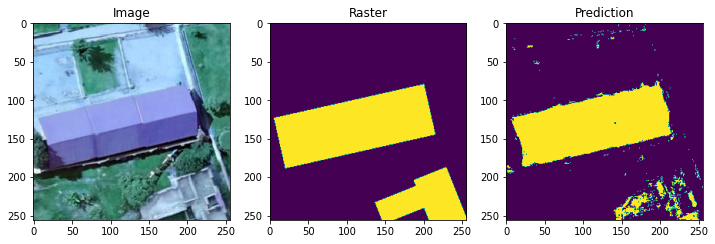

1/1 [==============================] - 0s 14ms/step


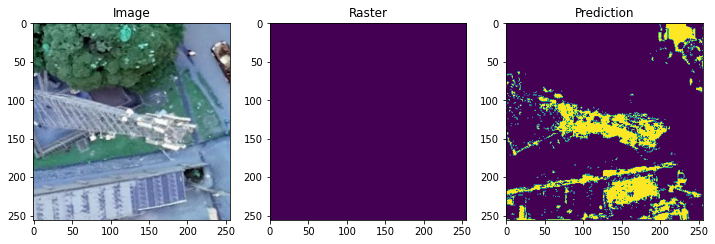

1/1 [==============================] - 0s 14ms/step


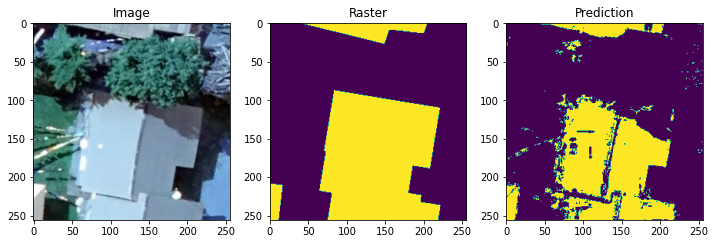

In [12]:
vis_results(X_test, new_vgg, load_model)
#Predictions for dataset 2

1/1 [==============================] - 0s 51ms/step


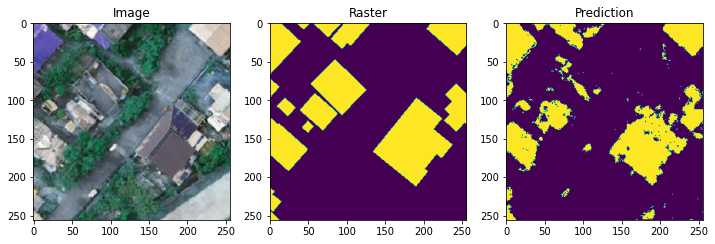

1/1 [==============================] - 0s 14ms/step


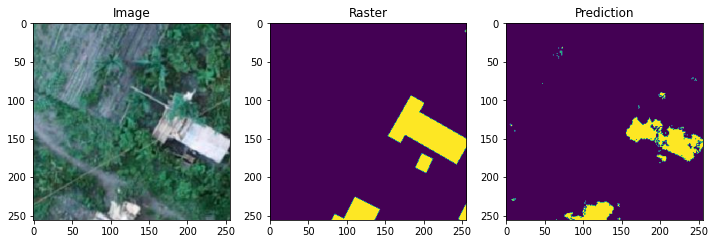

1/1 [==============================] - 0s 16ms/step


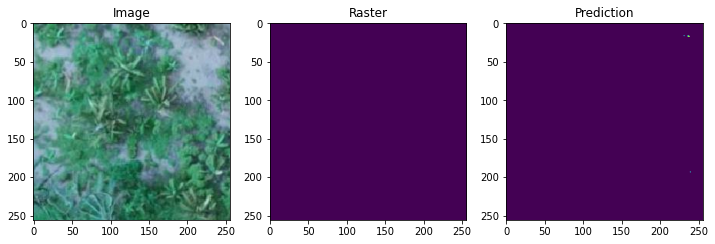

1/1 [==============================] - 0s 20ms/step


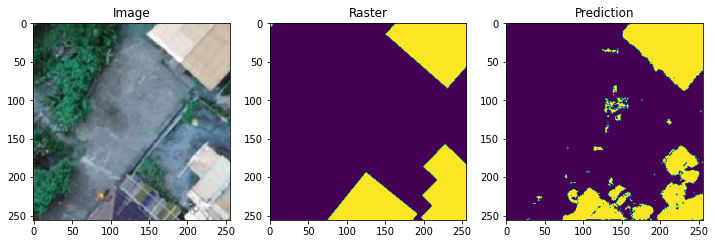

1/1 [==============================] - 0s 16ms/step


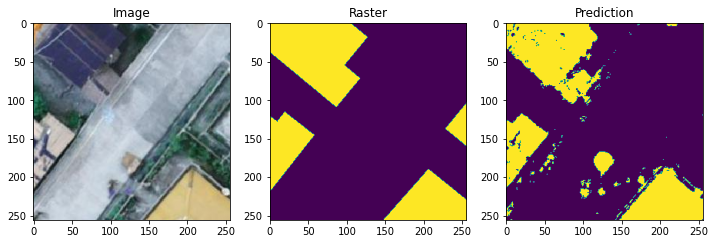

In [ ]:
vis_results(X_test, new_vgg, load_model)
#Predictions for dataset 3

In [1]:
#vis_results(X_test, new_vgg, load_model)
#Predictions for dataset 4